In [1]:
import pyopenms
from pyopenms import *

In [2]:
exp = MSExperiment()
# Load mzML file
MzMLFile().load("F:/FCI/Senior/1st Semester/Computational Biology Techniches/Project/Raw/Fusion_180220_07.mzML", exp)

spectra = exp.getSpectra()

In [53]:
# Get the spectrum number 10 (index number 9)

observed_spectrum = spectra[9]
print(observed_spectrum)

## Proteolytic Digestion with Trypsin

In [4]:
dig = ProteaseDigestion()
dig.getEnzymeName() # Trypsin

# Read all Fasta File Records 
bsa = "".join([l.strip() for l in open("Scerevisiae_UPS2_1802.fasta").readlines() if l.startswith('>') == False])

# Converet to amino acid
bsa = AASequence.fromString(bsa)

# create all digestion products
result = []
dig.digest(bsa, result)
len(result) # 333650 peptides

333650

In [54]:
# the peptide used
print(result[30].toString())

DISYMLSQQADAVQVGTAFLGCSESNASK


## Now we generate the theoretical spectrum of that peptide: 

In [55]:
tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")              
p.setValue("add_metainfo", "true")                          
tsg.setParameters(p)   

peptide = result[30]
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

## Now we can plot the observed and theoretical spectrum as a mirror plot:


251.31964111328125
1785.7156982421875


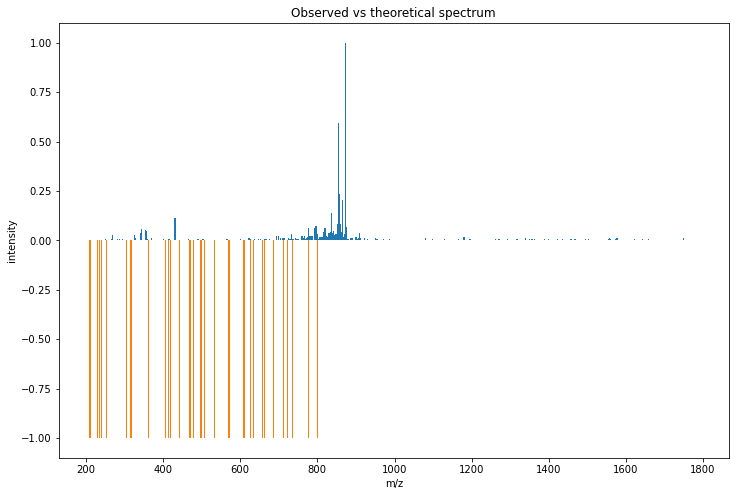

In [56]:
import numpy as np
from matplotlib import pyplot as plt

def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
  
    obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
    theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
    plt.figure(figsize=(12,8))
    plt.bar(obs_mz, obs_int, width = 3.0)
    plt.bar(theo_mz, theo_int, width = 3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')

obs_mz, obs_int = observed_spectrum.get_peaks()

# The mass-to-charge of our observed spectrum ranges from 147 - 1000 m/z
print(min(obs_mz)) # 147.0557861328125
print(max(obs_mz)) # 994.3831176757812

# We filter the peaks of the theoretical spectrum to fit the range (to reduce image complexity)
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
    if mz >= 200.0 and mz <= 800.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

title = 'Observed vs theoretical spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

## Now we want to find matching peaks between observed and theoretical spectrum. 

In [57]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()

# use 0.5 Da tolerance (Note: for high-resolution data we could also use ppm by setting the is_relative_tolerance value to true)
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)

# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

## The alignment contains a list of matched peak indices. We can simply inspect matching peaks with: 

In [58]:
# Print matching ions and mz from theoretical spectrum
print("Number of matched peaks: " + str(len(alignment)))
print("ion\ttheo. m/z\tobserved m/z")

for theo_idx, obs_idx in alignment:
    ion_name = theo_spectrum.getStringDataArrays()[0][theo_idx].decode()
    ion_charge = theo_spectrum.getIntegerDataArrays()[0][theo_idx]
    print(ion_name + "\t" + str(ion_charge) + "\t"
      + str(theo_spectrum[theo_idx].getMZ())
      + "\t" + str(observed_spectrum[obs_idx].getMZ()))

Number of matched peaks: 14
ion	theo. m/z	observed m/z
b5+	1	610.254128440871	610.0940551757812
b12++	2	662.2979137034711	662.3988647460938
b6+	1	723.338192791771	723.4190673828125
b14++	2	775.8614099746211	775.7384643554688
y16++	2	799.877591538421	800.3029174804688
b7+	1	810.370221951271	810.670654296875
b15++	2	825.3956171181711	825.4727172851562
y17++	2	849.411798681971	848.9219970703125
y18++	2	884.930355761721	885.22607421875
b17++	2	904.4301887776711	904.3136596679688
b21++	2	1098.5357172242711	1098.787353515625
y26++	2	1353.130917083721	1352.732421875
b13+	1	1422.6569652272715	1423.0804443359375
b28++	2	1437.649671695371	1438.1051025390625


## The mirror plot can also be used to visualize the aligned spectrum: 

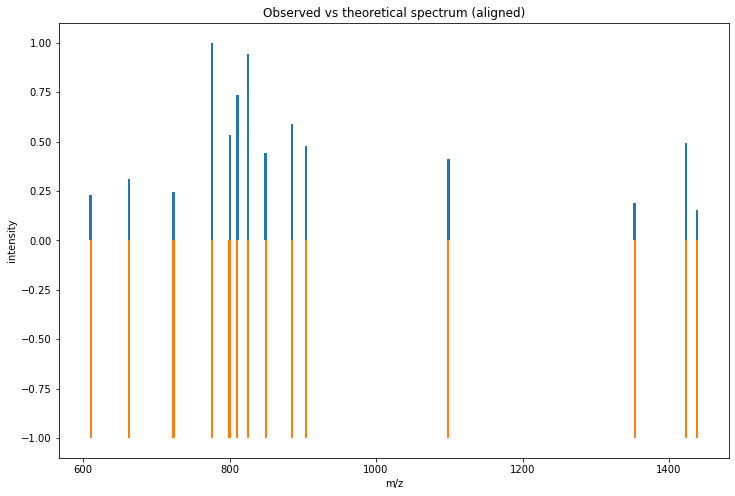

In [59]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'Observed vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)